<a href="https://colab.research.google.com/github/Satvik256/Graph-Convolutional-Networks/blob/main/GCN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Translating Graph into Features for Neural Networks***
###1. Adjacency matrix (A)
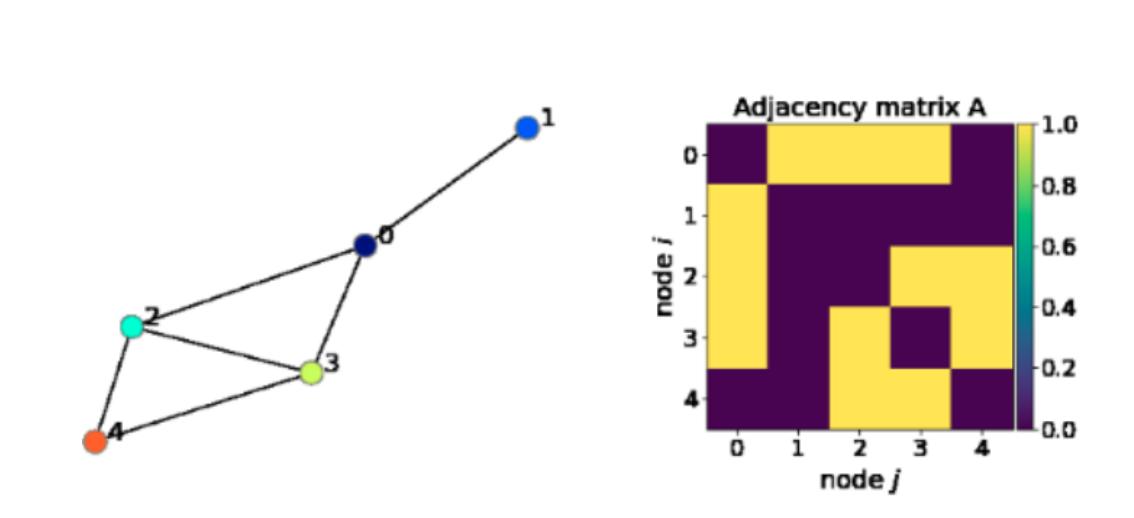
###2. Node attributes matrix (X)
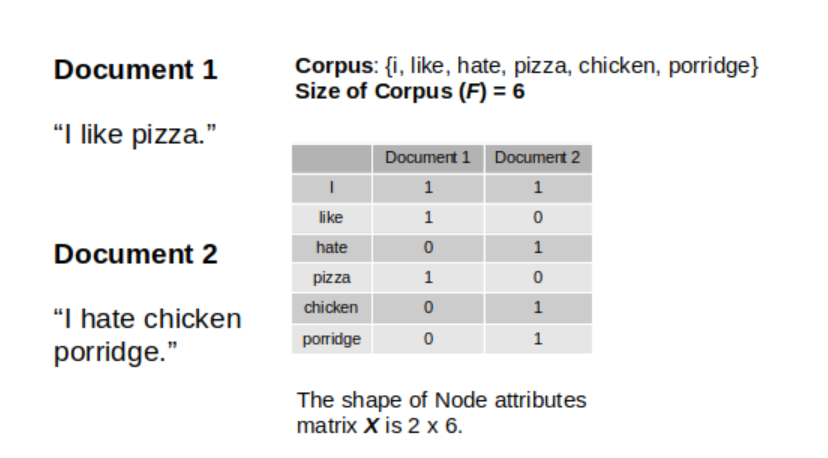
##3. Diagonal Matrix
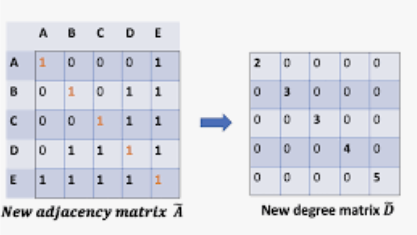

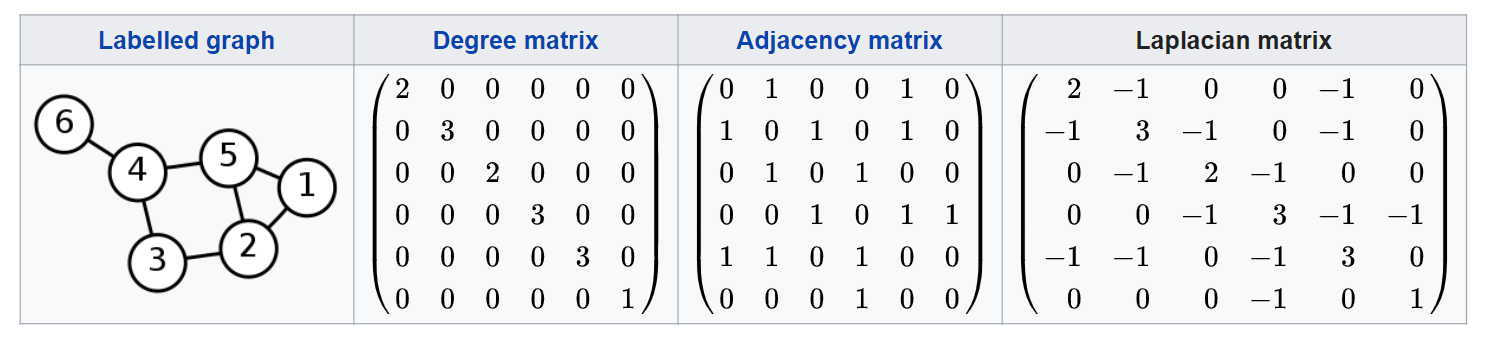

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Graph Info:
 Name: G
Type: Graph
Number of nodes: 6
Number of edges: 7
Average degree:   2.3333

Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


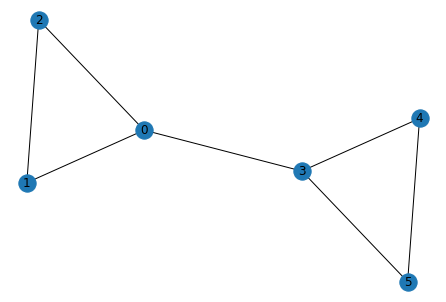

In [ ]:
G = nx.Graph(name='G')

for i in range(6):
    G.add_node(i, name=i)

edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]
G.add_edges_from(edges)

print('Graph Info:\n', nx.info(G))

print('\nGraph Nodes: ', G.nodes.data())

nx.draw(G, with_labels=True)
plt.show()

In [ ]:
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (6, 6)

Shape of X:  (6, 1)

Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


#**Forward Propogation in Graph Neural Networks**
###Let us look at a Simple Graph:
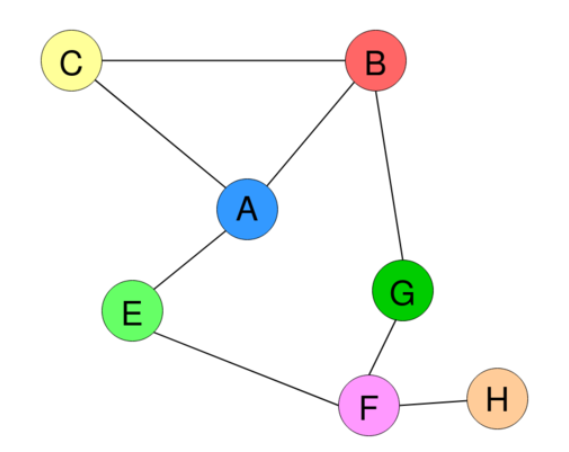

###We will focus now on person A. First of all, we just take a look at the friend circle with depth 0, e.g. just the person itself
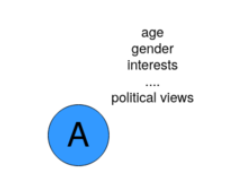

###That’s not too interesting. We can only infer from the features of the person. Now have a look at depth 1
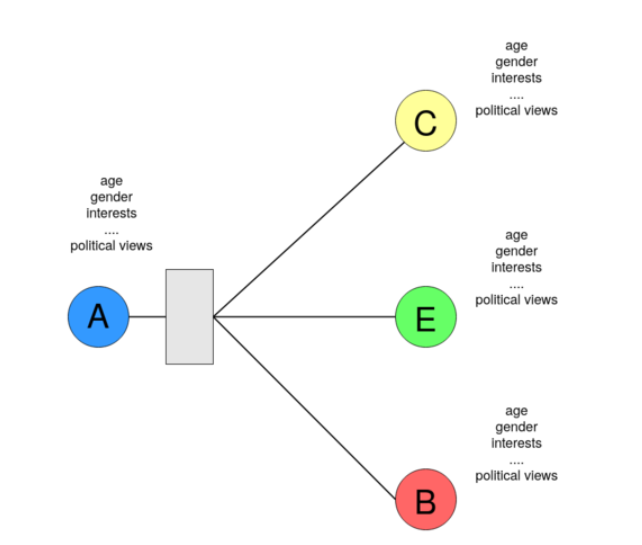

###Now we can also analyze features of the friends. Finally, a net with depth 2 looks like this:
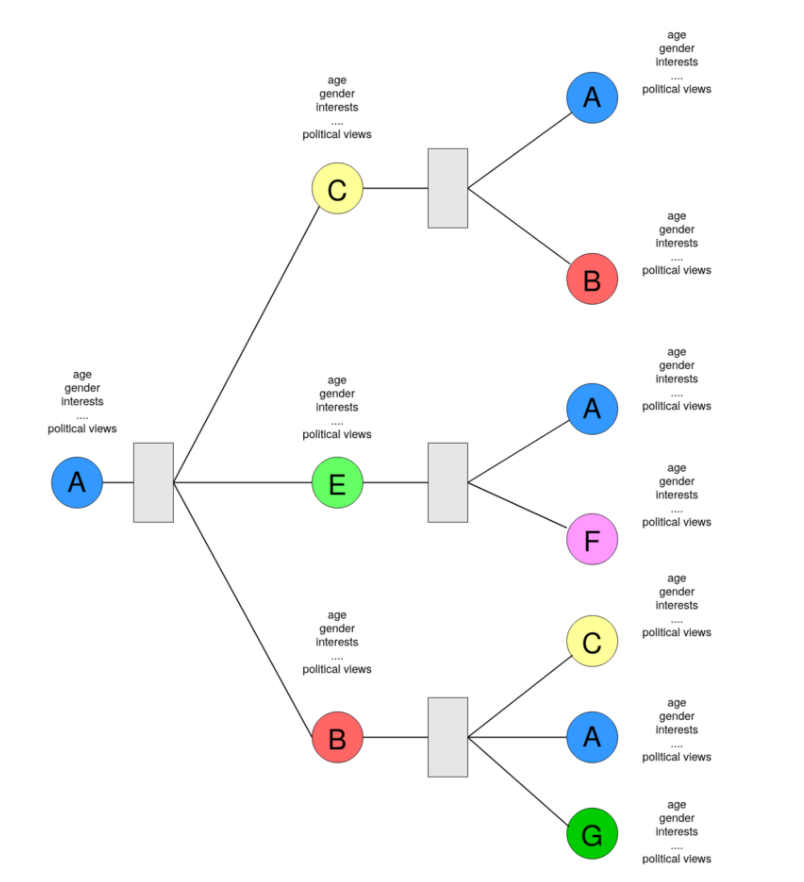

####Now this looks a lot like a neural network! And that’s what we basically do in these mysterious gray boxes: we somehow aggregate all the features of the neighboring nodes, multiply them with weights and apply an activation function. Note: we call the aggregated features embeddings
####Let’s have a closer look at what is going on in these boxes.Take a look at the two equations below:
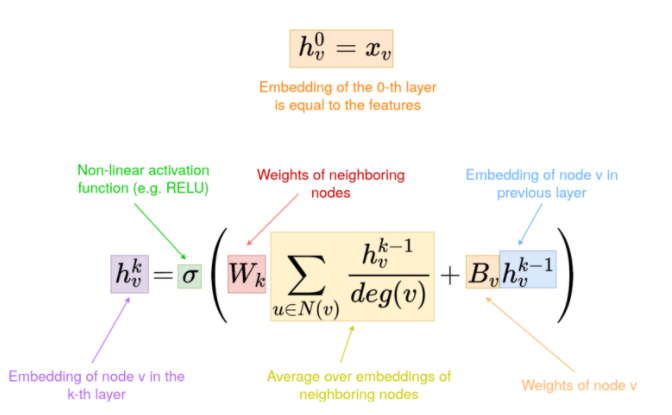

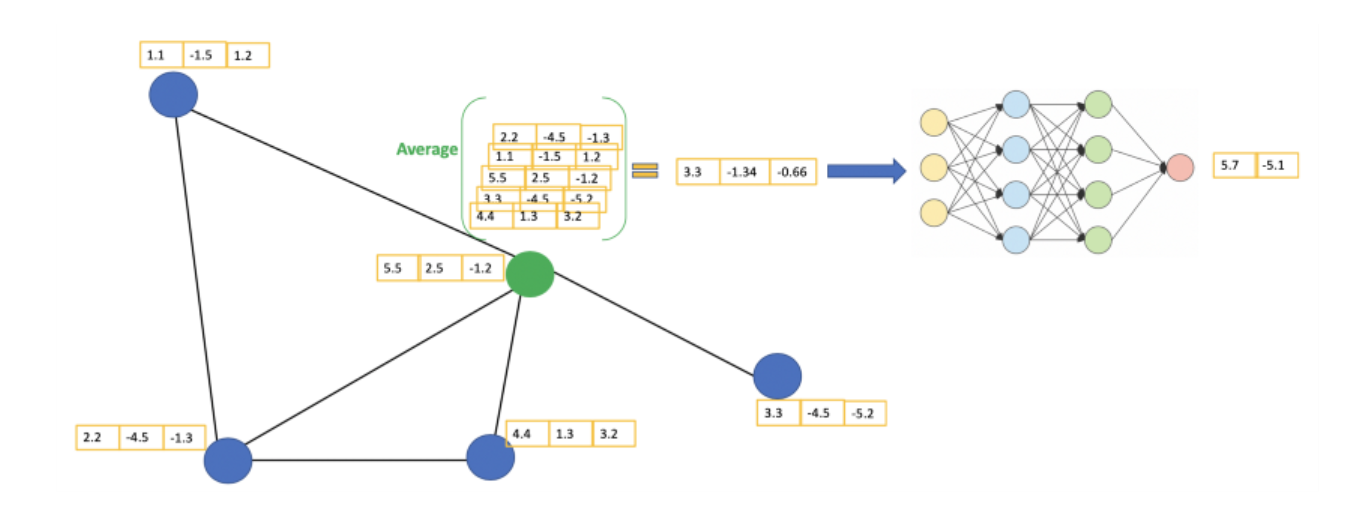

In [ ]:
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


In [ ]:
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)
print('Edges of G with self-loops:\n', G_self_loops.edges)
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]
Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


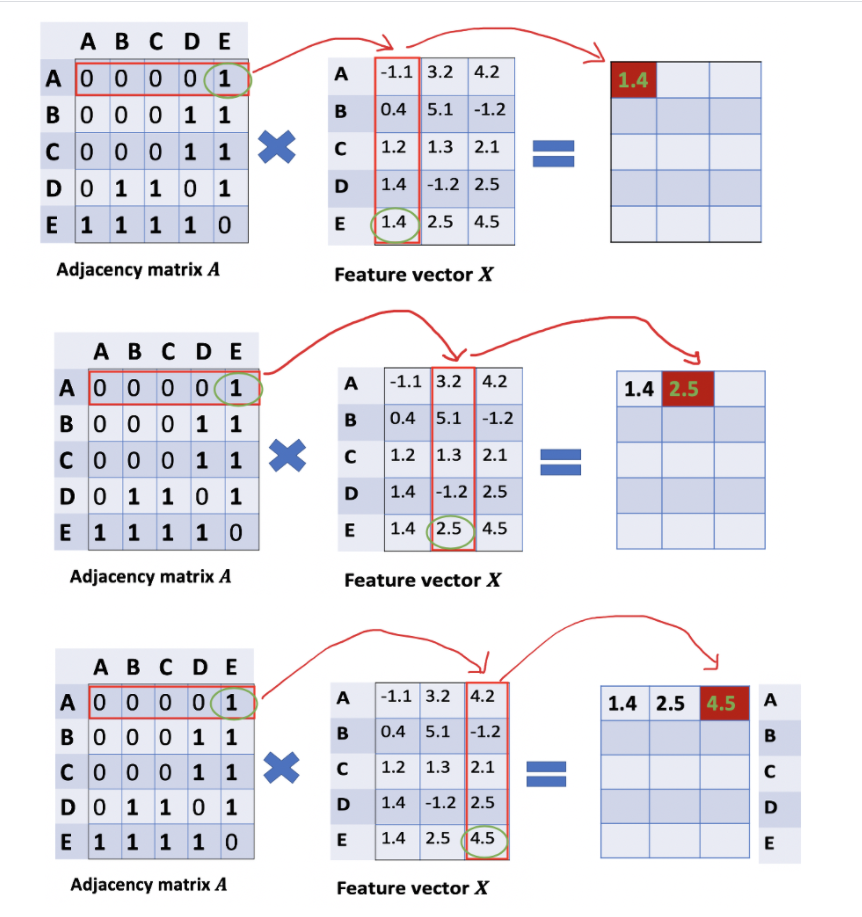

In [ ]:
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)
D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)
DAX = np.dot(D_inv,AX)
print('DAX:\n', DAX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


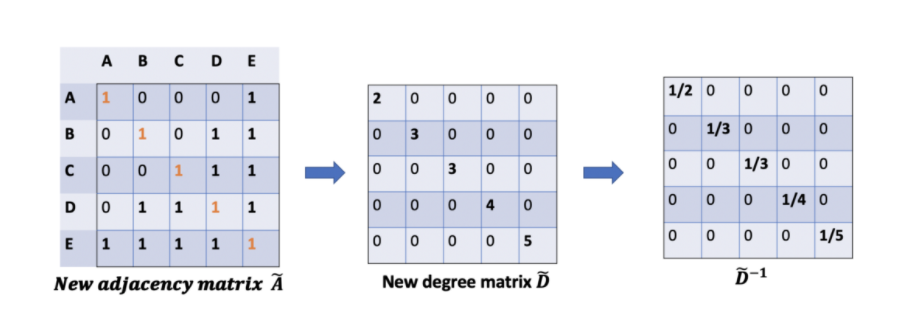

In [ ]:
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX)

DADX:
 [[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


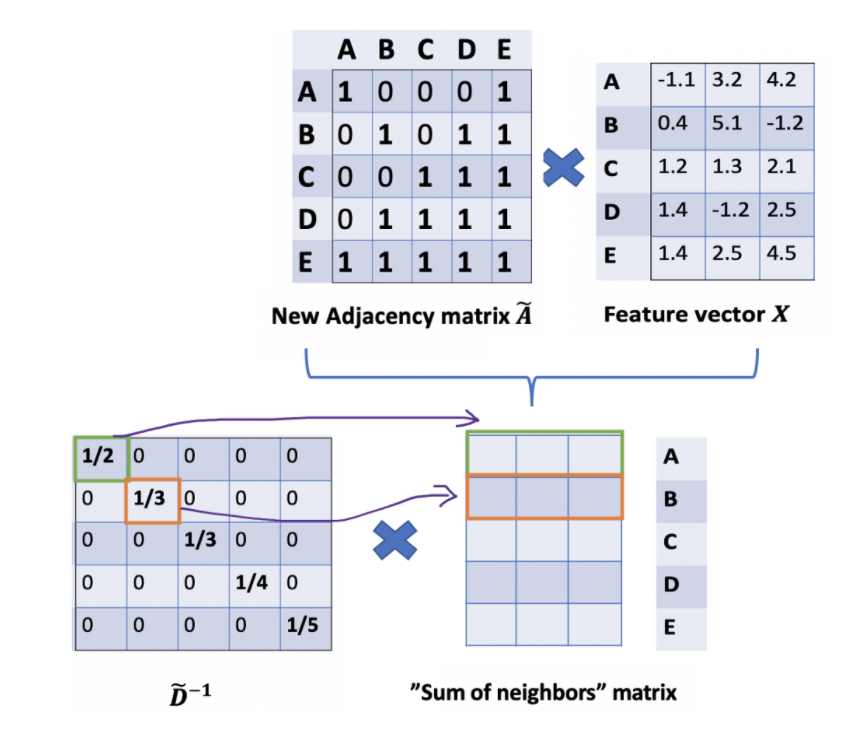

In [ ]:
np.random.seed(77777)
n_h = 4
n_y = 2 
W0 = np.random.randn(X.shape[1],n_h) * 0.01
W1 = np.random.randn(n_h,n_y) * 0.01
def relu(x):
    return np.maximum(0,x)
def gcn(A,H,W):
    I = np.identity(A.shape[0])
    A_hat = A + I 
    D = np.diag(np.sum(A_hat, axis=0))
    D_half_norm = fractional_matrix_power(D, -0.5)
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)
H1 = gcn(A,X,W0)
H2 = gcn(A,H1,W1)
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00027758 0.        ]
 [0.00017298 0.        ]
 [0.00017298 0.        ]
 [0.00053017 0.        ]
 [0.00054097 0.        ]
 [0.00054097 0.        ]]


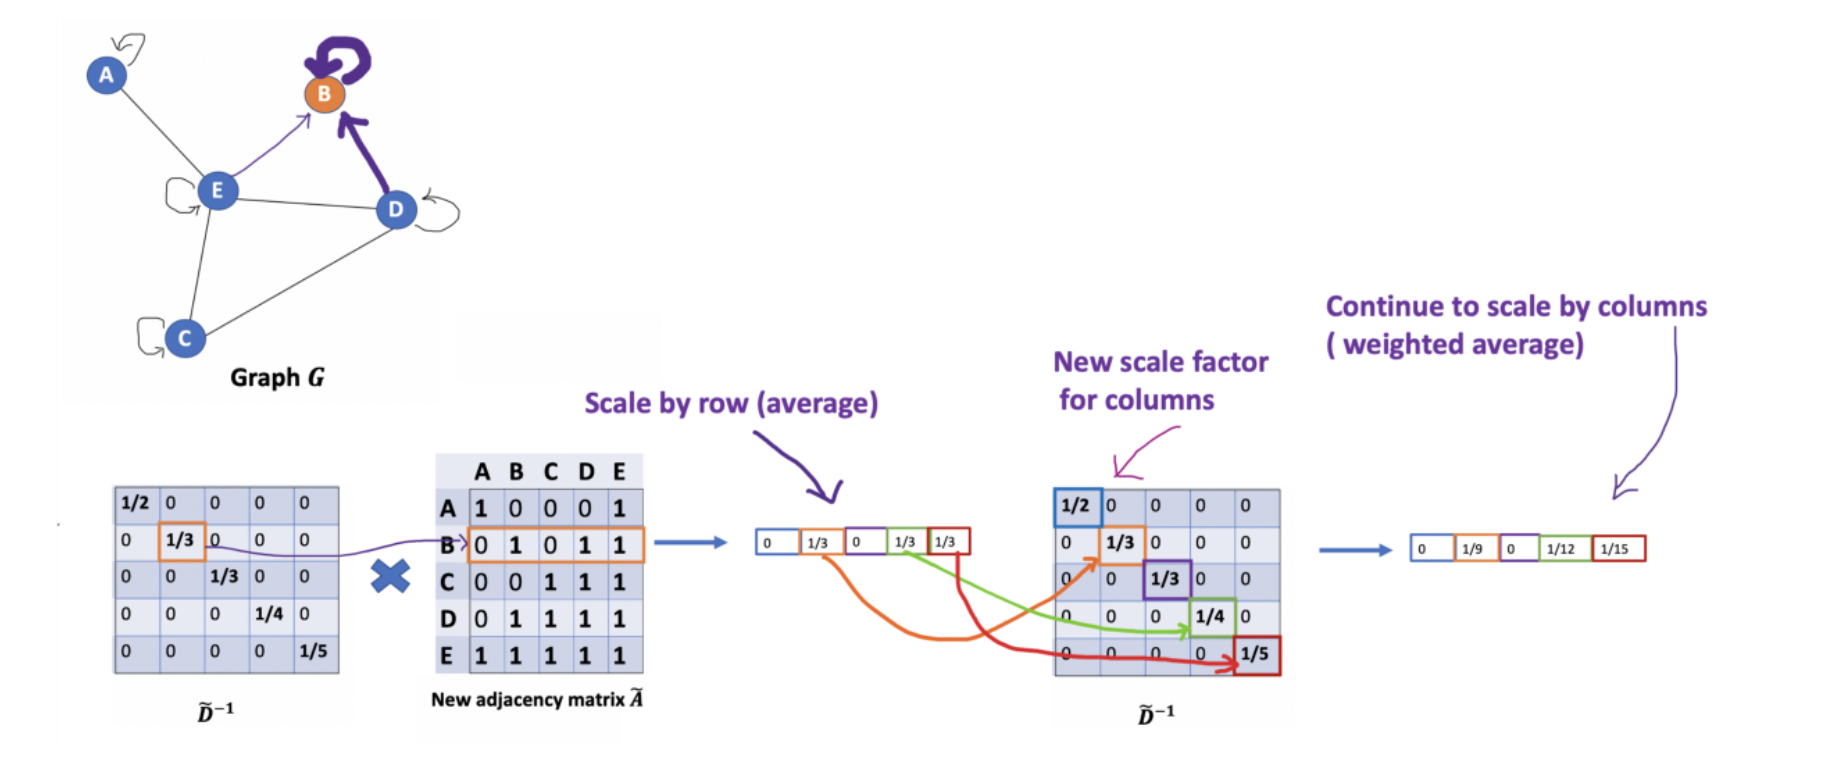

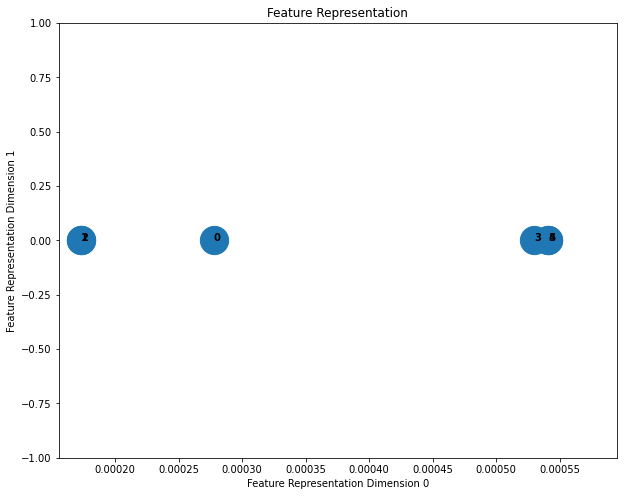

In [ ]:
def plot_features(H2):
    x = H2[:,0]
    y = H2[:,1]
    size = 800
    plt.figure(figsize=(10,8))
    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=10, fontweight='bold')
    plt.show()
plot_features(H2)

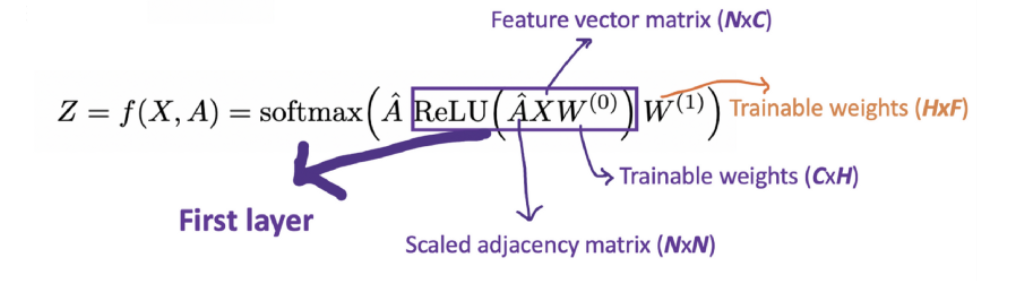